- Distinguish between PyTorch classes such as nn.Module and nn.Functional, and determine their appropriate usage.
- Customize training options, such as setting different learning rates for various layers and initializing weights.
- Utilize Scheduling with PyTorch.
- Saving and Loading your Model

#### nn.Functional vs nn.Module

The use of torch.nn.Module and torch.nn.functional in PyTorch often arises, especially when reading open-source code. Both are essential components for building neural network architectures, but they serve different purposes.

`torch.nn.Module` serves as the cornerstone of PyTorch. It allows users to define complex neural network architectures by creating custom modules. These modules encapsulate parameters and operations, making it easy to organize and reuse code. When using `torch.nn.Module`, you define a module object and then invoke its forward method to execute it. This approach follows an object-oriented paradigm.

On the other hand, `torch.nn.functional` provides a set of pre-defined layers and activation functions that can be directly applied to input tensors. These functions operate on tensors and are stateless, meaning they do not contain any parameters themselves. For example, to perform operations like rescaling an image tensor, you can call functions like `torch.nn.functional.interpolate` directly on the input tensor.

In [1]:
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True' # Required for matplotlib crash

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

inp = torch.randn(1,3,64,64)     # random input image

# torch.nn
avg_pool = nn.AvgPool2d(4)     # create an object
nn_out = avg_pool(inp)         # invoke the forward method

# torch.nn.Functional
f_out = F.avg_pool2d(inp, 4)

print (torch.equal(nn_out, f_out))  

True


So how do we choose what to use when? When the layer / activation / loss we are implementing has a loss.



#### Understanding the Stateful Nature of Layers

A layer in a neural network can be viewed as a function that transforms input data into output data through mathematical operations such as convolutions or matrix multiplications. However, layers in deep learning models also have parameters, or weights, that need to be learned during training. These weights are updated iteratively through optimization algorithms like gradient descent.

The crucial point to understand is that these weights are not fixed; they change as we train the model. This means that layers in neural networks have a state that evolves over time as we update the weights based on the training data.

To implement a layer as a function, we would need to handle the storage and update of these weights separately from the function itself. This introduces complexity and can be cumbersome to manage, especially as the number of layers and parameters in the model grows.

Alternatively, we can encapsulate both the function and its associated state (i.e., the weights) within a class. This approach simplifies the implementation by keeping the stateful variables within the class itself, eliminating the need to manage external data structures. In PyTorch, we achieve this by defining a class that inherits from `torch.nn.Module`, where each layer is implemented as a member function of the class.

Using `torch.nn.Module` objects is preferred when a layer requires weights or other stateful variables that influence its behavior during training. Examples include layers like dropout or batch normalization, which behave differently during training and inference.

On the other hand, for operations that do not require state or weights, such as resizing or average pooling, we can use the corresponding functions from `torch.nn.functional`. These functions operate directly on input tensors without maintaining any internal state.

Although most `torch.nn.Module` classes have equivalent functions in `torch.nn.functional`, it's essential to consider the stateful nature of layers during practical work. Choosing between `torch.nn.Module` and `torch.nn.functional` based on the presence of state or weights helps ensure clear and efficient implementation of neural network architectures.

#### nn.Parameter

An important class in PyTorch is the `nn.Parameter` class, which to my surprise, has gotten little coverage in PyTorch introductory texts. Consider the following case.

In [2]:
class net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv = nn.Linear(10,5)
    
  def forward(self, x):
    return self.linear(x)


myNet = net()
print(list(myNet.parameters()))

[Parameter containing:
tensor([[-0.1972, -0.2504,  0.0037, -0.1255,  0.1843, -0.2034, -0.2909, -0.2230,
          0.2202, -0.1253],
        [-0.1081,  0.0295,  0.1450, -0.1925,  0.0685, -0.0880,  0.0645, -0.0136,
          0.1366,  0.1008],
        [-0.3049, -0.1564,  0.2202,  0.1279,  0.0413, -0.0116,  0.0106, -0.0782,
          0.1009,  0.2774],
        [-0.2828,  0.0182, -0.0097, -0.1376,  0.2549, -0.1233, -0.1226,  0.0767,
         -0.2976,  0.1205],
        [ 0.0766,  0.0442,  0.0079,  0.1717,  0.1839, -0.1046,  0.0254,  0.2459,
          0.0909,  0.0334]], requires_grad=True), Parameter containing:
tensor([ 0.0823,  0.0625, -0.1644, -0.2324,  0.0243], requires_grad=True)]


Every `nn.Module` in PyTorch includes a `parameters()` function that returns its trainable parameters. These parameters are explicitly defined by the authors of PyTorch when they implement the module's functionality. For instance, in the definition of `nn.Conv2d`, the parameters representing the convolutional kernel weights and bias are explicitly defined.

However, it's worth noting that when we define a neural network (`net`), we don't need to explicitly add the parameters of each individual layer (`nn.Conv2d`, `nn.Linear`, etc.) to the parameters of the `net`. Instead, this process happens implicitly due to the way PyTorch handles the registration of parameters.

Internally, PyTorch utilizes the `nn.Parameter` class, which is a subclass of the Tensor class, to represent trainable parameters. When the `parameters()` function of an `nn.Module` object is invoked, it returns all of its members that are instances of `nn.Parameter`.

Moreover, all the trainable weights within `nn.Module` classes are implemented as `nn.Parameter` objects. When one `nn.Module` (e.g., `nn.Conv2d`) is assigned as a member of another `nn.Module` (e.g., `net`), the parameters of the assigned module (i.e., the weights of `nn.Conv2d`) are automatically added to the parameters of the object to which it's being assigned (parameters of net). This process is referred to as registering the parameters of an `nn.Module`.

It's important to note that if you try to assign a regular tensor to an `nn.Module` object, it won't be included in the parameters returned by the `parameters()` function unless you explicitly define it as an `nn.Parameter` object. This design choice allows for flexibility in scenarios where you might need to cache a non-differentiable tensor, such as caching previous outputs in recurrent neural networks (RNNs).

In [3]:
class net1(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv = nn.Linear(10,5)
    self.tens = torch.ones(3,4) 
    
  def forward(self, x):
    return self.linear(x)

myNet = net1()
print(list(myNet.parameters()))

[Parameter containing:
tensor([[-0.2800, -0.2969, -0.2541, -0.2142, -0.1865,  0.0554, -0.1238,  0.2148,
          0.1229, -0.0278],
        [ 0.1394,  0.0280, -0.2778, -0.2146, -0.0930,  0.0186,  0.0074,  0.3147,
         -0.2312,  0.2979],
        [-0.2382,  0.2633,  0.2655, -0.1762, -0.0289,  0.0482, -0.2789, -0.2819,
          0.0546,  0.0115],
        [ 0.0116,  0.0401,  0.2623, -0.1402,  0.1265, -0.2414, -0.0468,  0.1793,
          0.0407,  0.0255],
        [-0.1252, -0.0427,  0.1569, -0.1632, -0.1160,  0.2126,  0.0201, -0.0037,
         -0.3134,  0.0699]], requires_grad=True), Parameter containing:
tensor([-0.2379, -0.0660,  0.2595, -0.0033,  0.1164], requires_grad=True)]


In [4]:
class net2(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv = nn.Linear(10,5) 
    self.tens = nn.Parameter(torch.ones(3,4))
    
  def forward(self, x):
    return self.linear(x)


myNet = net2()
print(list(myNet.parameters()))

[Parameter containing:
tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]], requires_grad=True), Parameter containing:
tensor([[ 0.0675, -0.1424,  0.1650, -0.2677, -0.2785,  0.3050,  0.1304, -0.1756,
          0.0919, -0.0243],
        [-0.0186,  0.0041,  0.1209, -0.0411,  0.2620, -0.1601,  0.0917, -0.0100,
          0.0036,  0.0561],
        [-0.2973,  0.2082,  0.2299, -0.1645,  0.2716,  0.1492, -0.0174,  0.2474,
         -0.3013, -0.2150],
        [ 0.2291, -0.1482,  0.2357,  0.1155, -0.2492, -0.3007, -0.2570,  0.2553,
         -0.2120, -0.0186],
        [-0.2024, -0.3026, -0.0626, -0.2274,  0.0707, -0.0618,  0.1361, -0.0942,
         -0.1200,  0.1006]], requires_grad=True), Parameter containing:
tensor([-0.0016,  0.1711,  0.0386,  0.3026, -0.3049], requires_grad=True)]


In [5]:
class net3(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv = nn.Linear(10,5) 
    self.net  = net2()
    
  def forward(self, x):
    return self.linear(x)


myNet = net3()
print(list(myNet.parameters()))

[Parameter containing:
tensor([[ 0.1133, -0.1067, -0.0115, -0.2199,  0.0116,  0.1467, -0.0836,  0.0289,
          0.1971,  0.1057],
        [-0.0039, -0.1473,  0.2351,  0.0741,  0.1531, -0.2651,  0.0099, -0.0974,
         -0.1724, -0.0945],
        [ 0.1443, -0.1424, -0.2005,  0.0607, -0.0208,  0.2211, -0.1673, -0.1659,
         -0.3016, -0.0901],
        [-0.1222,  0.2375,  0.1785, -0.2714,  0.2844, -0.2399, -0.2231,  0.1849,
          0.1270, -0.1058],
        [-0.1723,  0.0931, -0.1755,  0.2425, -0.2066,  0.1930, -0.2187,  0.1941,
          0.0350,  0.1038]], requires_grad=True), Parameter containing:
tensor([ 0.1604, -0.0775, -0.1501, -0.2807, -0.0268], requires_grad=True), Parameter containing:
tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]], requires_grad=True), Parameter containing:
tensor([[ 0.2551,  0.2103, -0.2652, -0.2485,  0.2238, -0.2473,  0.0495, -0.1949,
          0.1658, -0.2232],
        [-0.0124, -0.1771, -0.2330, -0.2723, -0.2595,  0.195

#### nn.ModuleList and nn.ParameterList

In [6]:
layer_list = [nn.Conv2d(5,5,3), nn.BatchNorm2d(5), nn.Linear(5,2)]

class myNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = layer_list
  
  def forward(x):
    for layer in self.layers:
      x = layer(x)

net = myNet()

print(list(net.parameters())) 

[]


As you see, unlike when we would register individual modules, assigning a Python List doesn't register the parameters of Modules inside the list. To fix this, we wrap our list with the nn.ModuleList class, and then assign it as a member of the network class.

In [7]:
layer_list = [nn.Conv2d(5,5,3), nn.BatchNorm2d(5), nn.Linear(5,2)]

class myNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.ModuleList(layer_list)
  
  def forward(x):
    for layer in self.layers:
      x = layer(x)

net = myNet()

print(list(net.parameters())) 

[Parameter containing:
tensor([[[[-0.0248,  0.0262,  0.0701],
          [ 0.0708,  0.1023, -0.0748],
          [ 0.1310, -0.0304, -0.0038]],

         [[ 0.1292, -0.0098, -0.0568],
          [-0.0086,  0.1000,  0.0903],
          [-0.0510, -0.1404, -0.0107]],

         [[ 0.0700,  0.0678,  0.0759],
          [-0.1122,  0.0283, -0.1265],
          [-0.1018,  0.0413, -0.0480]],

         [[ 0.0096,  0.1433,  0.0346],
          [ 0.0484,  0.0780, -0.1206],
          [-0.0040, -0.0600, -0.0282]],

         [[ 0.0800,  0.1195,  0.0745],
          [ 0.1180,  0.1145, -0.0248],
          [ 0.0890, -0.1108,  0.0701]]],


        [[[ 0.0334, -0.1053, -0.0740],
          [ 0.0668,  0.0229, -0.1259],
          [ 0.0812, -0.1259, -0.0307]],

         [[ 0.1404,  0.1040, -0.0406],
          [-0.1438, -0.1406, -0.0927],
          [-0.1313, -0.0680, -0.0595]],

         [[-0.1411,  0.0346,  0.0881],
          [ 0.0185,  0.0202,  0.0587],
          [ 0.0161, -0.0022,  0.0624]],

         [[ 0.0432, -0.

Similarly, a list of tensors can be registered by wrapping the list inside a `nn.ParameterList` class.



#### Weight Initialization

Weight initialization plays a crucial role in the training of neural networks, as it can significantly influence the convergence speed and final performance of the model. Moreover, different types of layers may require different weight initialization schemes to ensure effective training.

In PyTorch, the `modules()` function is a member function of the nn.Module class. It returns an iterator containing all the member nn.Module objects of the parent `nn.Module object. This allows us to access each individual layer within a neural network.

Once we have access to each layer, we can use the apply() function to apply specific initialization schemes to the parameters of each layer. The apply() function takes as input a function or callable object that applies the desired initialization scheme to the parameters of the layer.

Here's a simplified example of how we can use modules() and apply() to initialize the weights of different layers in a neural network:

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)


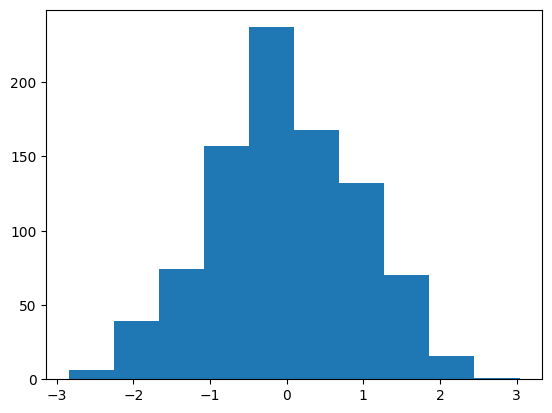

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

class myNet(nn.Module):
 
  def __init__(self):
    super().__init__()
    self.conv = nn.Conv2d(10,10,3)
    self.bn = nn.BatchNorm2d(10)
  
  def weights_init(self):
    for module in self.modules():
        if isinstance(module, nn.Conv2d):
            nn.init.normal_(module.weight, mean = 0, std = 1)
            nn.init.constant_(module.bias, 0)

Net = myNet()
Net.weights_init()

for module in Net.modules():
    if isinstance(module, nn.Conv2d):
        weights = module.weight
        weights = weights.reshape(-1).detach().cpu().numpy()
        print(module.bias)
        plt.hist(weights)
        plt.show()

#### modules vs children

`modules()` and `children()` are both functions in PyTorch's `nn.Module` class that allow us to access the submodules (i.e., layers) within a neural network. While they serve similar purposes, there is a subtle but important difference between them.

The `children()` function returns an iterable containing only the direct child modules (i.e., immediate submodules) of the parent module. These child modules are the ones directly assigned as attributes of the parent module.

On the other hand, the `modules()` function recursively goes through all submodules of the parent module, including submodules of submodules, and so on. It returns an iterable containing all modules within the hierarchy of the parent module.

Here's a simple example to illustrate the difference between `children()` and `modules()`:

In [4]:
import torch
import torch.nn as nn

class MyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.convBN = nn.Sequential(nn.Conv2d(10, 10, 3), nn.BatchNorm2d(10))
        self.linear = nn.Linear(10, 2)
    
    def forward(self, x):
        pass

net = MyNet()

print("Printing children\n------------------------------")
print(list(net.children()))
print("\n\nPrinting Modules\n------------------------------")
print(list(net.modules()))

Printing children
------------------------------
[Sequential(
  (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
), Linear(in_features=10, out_features=2, bias=True)]


Printing Modules
------------------------------
[MyNet(
  (convBN): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (linear): Linear(in_features=10, out_features=2, bias=True)
), Sequential(
  (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
), Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1)), BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), Linear(in_features=10, out_features=2, bias=True)]


#### Printing Information About the Network

Printing information about a neural network in PyTorch can be useful for both users and debugging purposes. PyTorch provides several named functions to access information about the network's parameters, modules, children, and buffers. These functions allow us to iterate through the network's components while also providing their names for easy identification.

Here's a brief overview of the four named functions available in PyTorch:

1. `named_parameters`: Returns an iterator containing tuples of parameter names and their corresponding values. Parameters typically include weights and biases of the network's layers.

2. `named_modules`: Similar to named_parameters, but returns an iterator containing tuples of module names and their corresponding modules. This function traverses through all modules within the network, including nested modules.

3. `named_children`: Like named_modules, but specifically returns an iterator containing tuples of child module names and their corresponding modules. This function only traverses through direct child modules of the network.

4. `named_buffers`: Returns an iterator containing tuples of buffer names and their corresponding tensor values. Buffers often include non-learnable parameters, such as running mean and variance in batch normalization layers.

Here's a simple example demonstrating the usage of these named functions:

In [5]:
import torch
import torch.nn as nn

# Define a custom neural network
class MyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(64 * 28 * 28, 10)

    def forward(self, x):
        pass

# Create an instance of the network
net = MyNet()

# Print information about the network's parameters
print("Named Parameters:")
for name, param in net.named_parameters():
    print(name, param.shape)

# Print information about the network's modules
print("\nNamed Modules:")
for name, module in net.named_modules():
    print(name, module)

# Print information about the network's children
print("\nNamed Children:")
for name, child in net.named_children():
    print(name, child)

# Print information about the network's buffers
print("\nNamed Buffers:")
for name, buffer in net.named_buffers():
    print(name, buffer.shape)

Named Parameters:
conv1.weight torch.Size([64, 3, 3, 3])
conv1.bias torch.Size([64])
bn1.weight torch.Size([64])
bn1.bias torch.Size([64])
fc.weight torch.Size([10, 50176])
fc.bias torch.Size([10])

Named Modules:
 MyNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (fc): Linear(in_features=50176, out_features=10, bias=True)
)
conv1 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
bn1 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
relu ReLU()
fc Linear(in_features=50176, out_features=10, bias=True)

Named Children:
conv1 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
bn1 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
relu ReLU()
fc Linear(in_features=50176, out_features=10, bias=True)

Named Buffers:
bn1.running_mean torch.Size([64])
bn1.running_var t

#### Differential Learning Rate

This capability allows us to fine-tune the training process by adjusting the learning rates based on the specific requirements of different parts of the network.

The implementation of this concept is straightforward. In our previous example where we created a CIFAR classifier, we passed all the network's parameters as a single group to the optimizer object:

In [6]:
class MyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(10, 5)
        self.fc2 = nn.Linear(5, 2)
    
    def forward(self, x):
        return self.fc2(self.fc1(x))

net = MyNet()
optimizer = torch.optim.SGD(net.parameters(), lr=0.5)

However, PyTorch's `torch.optim` class allows us to specify different sets of parameters with distinct learning rates using a dictionary:

In [7]:
optimizer = torch.optim.SGD([
    {"params": net.fc1.parameters(), 'lr': 0.001, "momentum": 0.99},
    {"params": net.fc2.parameters()}
], lr=0.01, momentum=0.9)

In this scenario, the parameters of `fc1` are assigned a learning rate of `0.001` and a momentum of `0.99`. If a hyperparameter is not specified for a group of parameters (like `fc2`), they use the default value of that hyperparameter provided as an input argument to the optimizer function.

Alternatively, if we want to set different hyperparameters for biases and weights separately, we can do so by separating them and then configuring the optimizer accordingly:

In [8]:
params_bias = []
params_weights = []

# Separate the bias and weight parameters
for name, parameter in net.named_parameters():
    if "bias" in name:
        params_bias.append(parameter)
    elif "weight" in name:
        params_weights.append(parameter)

# Set the optimizer to have different hyperparameters for biases and weights
optimizer = torch.optim.SGD([
    {"params": params_bias, 'lr': 0.001, "momentum": 0.99},
    {"params": params_weights}
], lr=0.01, momentum=0.9)

This approach allows us to fine-tune the training process by customizing the learning rates for different layers or types of parameters in the neural network.

#### Scheduling Learning Rates

Scheduling learning rates is a critical aspect of training neural networks, and PyTorch offers support for various learning rate schedules through its torch.optim.lr_scheduler module. One such example is demonstrated below:

In [10]:
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 20], gamma=0.1)

In the above example, the scheduler multiplies the learning rate by the specified `gamma` factor each time the training reaches an epoch contained in the `milestones` list. For instance, the learning rate is multiplied by 0.1 at the 10th and 20th epochs.

To integrate this scheduler into your training loop, you need to ensure that you call `scheduler.step()` at the beginning of the epoch loop. Typically, the training loop consists of two nested loops: one iterating over epochs and the other over batches within each epoch. The `scheduler.step()` should be placed outside the batch loop to update the learning rate at the start of each epoch. Avoid placing it inside the batch loop, as this may lead to unintended updates to the learning rate.

It's important to note that `scheduler.step()` should not replace `optimizer.step()`. You still need to call `optimizer.step()` every time you perform backpropagation (inside the batch loop), while `scheduler.step()` updates the learning rate at the beginning of each epoch.

Here's a basic structure of how you would integrate the scheduler into your training loop:

In [13]:
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 20], gamma=0.1)

# for epoch in range(num_epochs):
#     scheduler.step()  # Update learning rate at the start of each epoch
    
#     # Training loop
#     for batch_idx, (inputs, targets) in enumerate(train_loader):
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, targets)
#         loss.backward()
#         optimizer.step()  # Backpropagation
        
#     # Validation loop (if applicable)
#     # Calculate validation loss and other metrics
    
#     print(f"Epoch {epoch+1}/{num_epochs}, Learning Rate: {scheduler.get_last_lr()}")

In this example, scheduler.get_last_lr() retrieves the learning rate after the scheduler has been updated. Adjust this structure according to your specific training setup and requirements.

#### Saving Model

Saving your model in PyTorch can be achieved in two ways: using `torch.save()` to save the entire model or using the model's `state_dict` to save only the parameters. Let's explore both methods:

**Saving the Entire Model**

In [14]:
# Save the entire model
torch.save(Net, "net.pth")

# Load the model
Net = torch.load("net.pth")

# Print the loaded model
print(Net)

myNet(
  (conv): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (bn): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In this approach, the entire model, including its architecture and weights, is serialized and saved to disk. Later, you can load the model back into memory using `torch.load()`.

**Saving and Loading Model's State Dict**

In [15]:
# Save the model's state dict (parameters only)
torch.save(Net.state_dict(), "net_state_dict.pth")

# Load the state dict
Net.load_state_dict(torch.load("net_state_dict.pth"))

# Print the loaded state dict
for key in Net.state_dict():
    print(key, Net.state_dict()[key])

conv.weight tensor([[[[-1.0087e+00, -1.3472e-01,  5.5503e-01],
          [ 7.5895e-01,  2.0397e-01,  6.3517e-01],
          [-6.7221e-01, -2.3866e+00,  2.3710e-01]],

         [[-2.1001e+00, -4.5312e-01, -1.2131e+00],
          [ 4.4503e-02, -2.4762e-01,  1.5118e+00],
          [ 1.0428e+00,  3.0670e-01,  1.8215e+00]],

         [[ 4.9656e-01,  1.0795e+00,  1.2628e+00],
          [ 5.6638e-02,  6.2805e-01, -9.7419e-01],
          [-1.1829e+00, -4.9368e-01,  1.2095e+00]],

         [[-2.1280e-01, -1.4508e+00, -1.2144e+00],
          [ 1.3363e+00, -6.7043e-01, -2.0833e-01],
          [-3.5866e-01,  1.2548e+00,  1.1278e+00]],

         [[ 5.1350e-01, -9.2347e-01,  3.0960e-01],
          [-4.4869e-02,  1.2497e+00,  9.3222e-01],
          [-1.9099e-01, -4.5086e-01,  8.8910e-01]],

         [[-1.7785e+00, -5.9751e-01, -2.7587e-01],
          [ 1.8195e-01, -1.0054e+00, -2.6742e-01],
          [-5.4385e-01,  2.8419e-01,  8.2707e-02]],

         [[ 1.0776e+00, -9.5793e-01,  5.3833e-01],
       

Here, only the model's parameters (state_dict) are saved to disk. When loading, ensure that the network architecture matches the one used during saving to avoid errors.

It's important to note that saving the entire model saves the architecture information as well, which can be convenient but may result in larger file sizes. On the other hand, saving only the state_dict is more space-efficient but requires you to recreate the model architecture before loading the parameters.

Additionally, you can save and load the state_dict of an optimizer object in a similar manner to maintain the state of optimization algorithms across different sessions.